In [28]:
from collections import defaultdict
import os
import csv

# csv_dir = "../log/ms-marco/vectors-colbert/k10_s1K_v137K/dtw"
# csv_dir = "../log/droid/vectors-dinov2/full-Intv_30-10-1K/dtw"
# csv_dir = "../log/droid/vectors-dinov2/full-Intv_30-10-10K/dtw"
# csv_dir = "../log/microlens/vectors-dinov2/full-None-10-1K/dtw"

csv_dir = "../log/ms-marco/vectors-colbert/k10_s1K_v137K/maxsim"
# csv_dir = "../log/ms-marco/vectors-colbert/k10_s10K_v1M/maxsim"
# csv_dir = "../log/ms-marco/vectors-colbert/k10_s100K_v2M/maxsim"
# csv_dir = "../log/droid/vectors-dinov2/full-Intv_30-10-1K/maxsim"
# csv_dir = "../log/microlens/vectors-dinov2/full-None-10-1K/maxsim"

data_dict = defaultdict(list)

for csv_name in os.listdir(csv_dir):
    if not csv_name.endswith(".csv"):
        continue

    algm, _, time = csv_name[:-4].partition("-query-")
    filepath = os.path.join(csv_dir, csv_name)

    with open(filepath, newline="", encoding="utf-8") as f:
        reader = csv.reader(f)
        rows = list(reader)

    if not rows:
        continue

    header, data_rows = rows[0], rows[1:]
    if not data_rows:
        continue

    records = {h: [] for h in header}
    for row in data_rows:
        for h, v in zip(header, row):
            records[h].append(int(v))

    data_dict[algm].append((time, records))

for algm in data_dict:
    data_dict[algm].sort(key=lambda x: x[0], reverse=True)

data_dict

defaultdict(list,
            {'set_hnsw': [('260108-151316',
               {'ef': [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
                'time': [220009,
                 313833,
                 474111,
                 594244,
                 689825,
                 759595,
                 813047,
                 856268,
                 889758,
                 921487,
                 940061],
                'hit': [805, 886, 947, 969, 986, 990, 992, 995, 996, 998, 999],
                'total': [1000,
                 1000,
                 1000,
                 1000,
                 1000,
                 1000,
                 1000,
                 1000,
                 1000,
                 1000,
                 1000],
                'q_num': [100,
                 100,
                 100,
                 100,
                 100,
                 100,
                 100,
                 100,
                 100,
                 100,
        

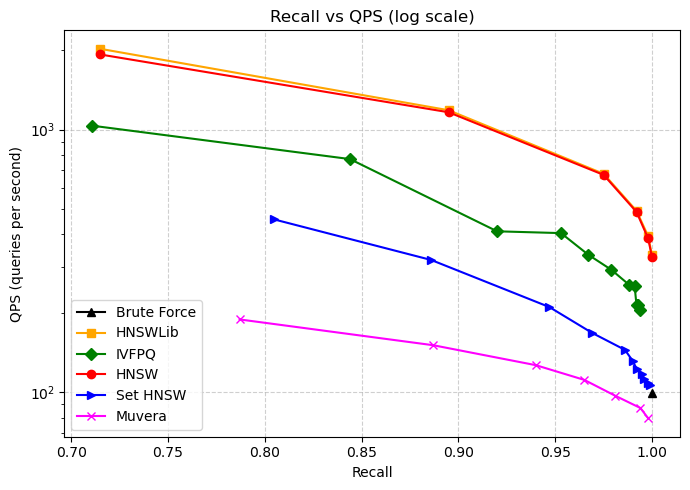

In [29]:
import matplotlib.pyplot as plt


plot_styles = {
    "brute_force": {"color": "black", "marker": "^", "label": "Brute Force"},
    "hnswlib": {"color": "orange", "marker": "s", "label": "HNSWLib"},
    "ivfpq": {"color": "green", "marker": "D", "label": "IVFPQ"},
    "hnsw": {"color": "red", "marker": "o", "label": "HNSW"},
    "set_hnsw": {"color": "blue", "marker": ">", "label": "Set HNSW"},
    "muvera": {"color": "magenta", "marker": "x", "label": "Muvera"},
    # "sketch_hnsw": [
    #     {"color": "cyan", "marker": "p", "label": "Sketch HNSW"},
    # ],
}


def get_records(algm, index):
    if algm not in data_dict:
        return None
    if isinstance(index, int):
        return data_dict[algm][index][1]
    elif isinstance(index, str):
        for time, records in data_dict[algm]:
            if time == index:
                return records


def extract_xy(records):
    recall = [h / t for h, t in zip(records["hit"], records["total"])]
    qps = [q / (t / 1e6) for q, t in zip(records["q_num"], records["time"])]
    return recall, qps


plt.figure(figsize=(7, 5))

for algm, styles in plot_styles.items():
    if not isinstance(styles, list):
        styles = [styles]
    for style in styles:
        records = get_records(algm, style.get("time", 0))
        if records is None:
            continue
        recall, qps = extract_xy(records)
        plt.plot(recall, qps, marker=style["marker"], color=style["color"], label=style["label"], linewidth=1.5)

plt.xlabel("Recall")
plt.ylabel("QPS (queries per second)")
plt.yscale("log")
plt.title("Recall vs QPS (log scale)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

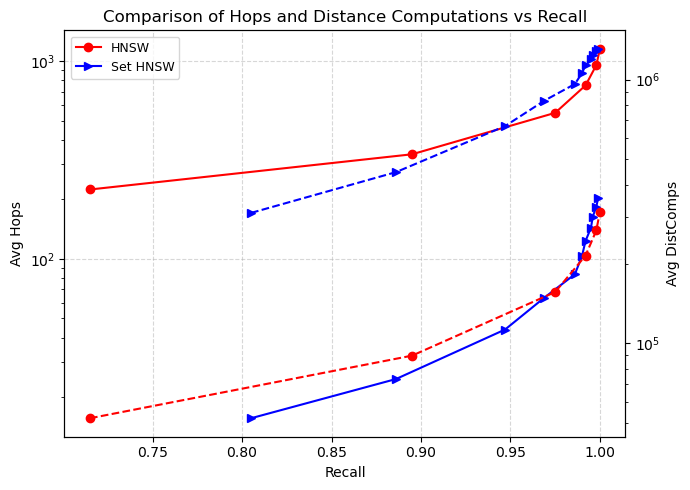

In [30]:
import matplotlib.pyplot as plt

def extract_metrics(records):
    ef_values = records["ef"]
    hops = [h / q for h, q in zip(records["hops"], records["q_num"])]
    dists = [d / q for d, q in zip(records["dist_comps"], records["q_num"])]
    recall = [h / t for h, t in zip(records["hit"], records["total"])] if "hit" in records and "total" in records else None
    return ef_values, recall, hops, dists


fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

for algm, styles in plot_styles.items():
    if not isinstance(styles, list):
        styles = [styles]
    for style in styles:
        records = get_records(algm, style.get("time", 0))
        if records is None:
            continue
        if not {"hops", "dist_comps", "hit", "total"}.issubset(records):
            continue

        ef, recall, hops, dists = extract_metrics(records)
        if recall is None:
            continue

        ax1.plot(recall, hops, marker=style["marker"], color=style["color"], linestyle="-", label=f"{style['label']}")
        ax2.plot(recall, dists, marker=style["marker"], color=style["color"], linestyle="--", label=f"{style['label']}")

ax1.set_xlabel("Recall")
ax1.set_ylabel("Avg Hops")
ax1.set_yscale("log")
ax2.set_ylabel("Avg DistComps")
ax2.set_yscale("log")

ax1.legend(loc="upper left", fontsize=9)
ax1.grid(True, linestyle="--", alpha=0.5)
plt.title("Comparison of Hops and Distance Computations vs Recall")
plt.tight_layout()
plt.show()
